# Full Processing Example

In this notebook, we provide a step-by-step guide to processing a single video stack and extracting all the relevant information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from microjet import filters, regions, process, dataio, measure

## Accessing the Raw Data

Here, we load the example data and display the first frame to gain an understanding of what the jet images look like.

In [2]:
# Load the data stack and the metadata 
image_stack_raw, metadata = dataio.h5_metadata("example_data/025.h5")

# Ensure the data is in float32 format to reduce the amount of data in memory
image_stack_raw = image_stack_raw.astype(np.uint8)

print("Number of Frames: ", image_stack_raw.shape[0], " -- Image Resolution: ", image_stack_raw.shape[1:])

Number of Frames:  120  -- Image Resolution:  (1024, 512)


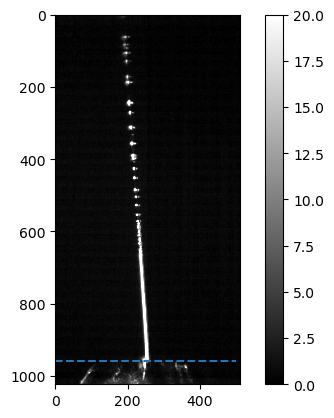

In [3]:
# Display the first frame of the raw data 
fig, ax = plt.subplots()
im = ax.imshow(image_stack_raw[10], cmap='gray', vmin=0, vmax=20)

# save the nozzle tip index position
ntip_idx = 960

ax.hlines(ntip_idx, xmin=0, xmax=500, linestyle="dashed")

fig.colorbar(im, ax=ax)
plt.show()

## Image Stack Cleanup 

We wish to convert our individual frames to binary images for easy processing. In this section, we 1) normalize the image stack, 2) filter the stack to remove the background, 3) threshold to convert it to a binary image, and 4) perform morphological operations to optimize the images.



### Normalizing the Image Stack

We begin by normalizing the image stack according to the typical brightness of the jet/dropet region. Note that we need to ignore the nozzle tip during normalization. In the above figure, we determined the index position of the nozzle tip to be 960, indicated by the blue dashed line.  


In [4]:
# Make a copy of the raw data so we don't mess with it
image_stack = image_stack_raw.copy().astype(np.float32)#.astype(np.uint8)



# Normalize the image stack to determine the typical brightness of a jet
for i in range(image_stack.shape[0]):
    # only use nonzero values for the normalization
    nonz = np.nonzero(image_stack[i,:ntip_idx,:]) # ignore the nozzle tip
    # divide by the median pixel value of the whole stack
    image_stack[i, :, :] /= np.median(image_stack[i][nonz])

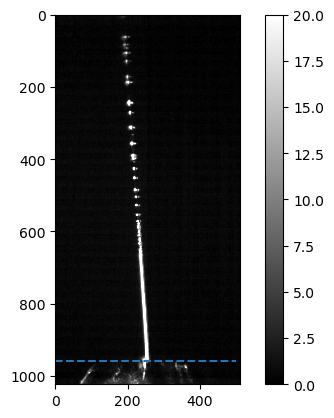

In [5]:
# Display the result to check on the normalization
fig, ax = plt.subplots()
im = ax.imshow(image_stack[10], cmap='gray', vmin=0, vmax=20)
ax.hlines(ntip_idx, xmin=0, xmax=500, linestyle="dashed")
fig.colorbar(im, ax=ax)
plt.show()

 ### Noise Reduction by Filtering
 
While the example data has a relatively flat background, we need to filter the image stack so the background pixel values are set to 0 and to reduce the amount of noise in the images. This step is generally necessary, especially with brightfield data. In the case of the example data, the image quality could warrant skipping this step and proceeding directly to the thresholding. For completnessness, we will include an example of the filtering step here. Before we do so, it is beneficial to plot a histogram of the pixel values before and after the filtering takes place to visualize the process. 

In [6]:
# manually add a couple frames with high intensity to test the outlier algorithms
for i in [10, 32, 55, 76]:
    image_stack[i] *= 100 

# Filter the image stack using a Sobel filter
image_stack_filtered = filters.sobel(image_stack)

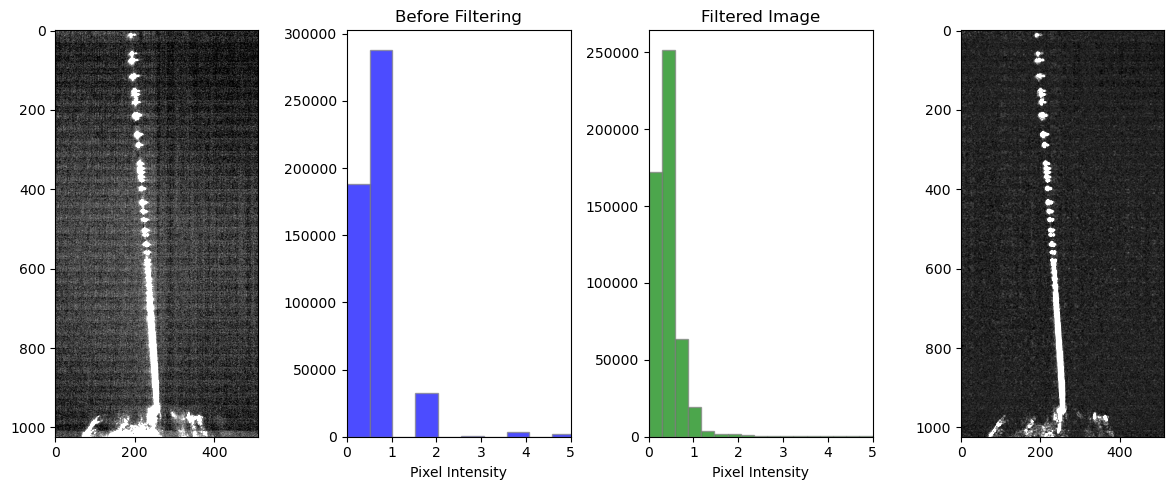

In [7]:
fig, ax = plt.subplots(1,4, figsize=(12,5), tight_layout=True)
ax[0].imshow(image_stack[0], cmap='gray', vmin=0, vmax=3)
ax[1].hist(image_stack[0].flatten(), bins=500, color='blue', alpha=0.7, edgecolor='gray')
ax[2].hist(image_stack_filtered[0].flatten(), bins=500, color='green', alpha=0.7, edgecolor='gray')
ax[3].imshow(image_stack_filtered[0], cmap='gray', vmin=0, vmax=3)
for i,title in enumerate(['Before Filtering', 'After Sobel Filter']):
    ax[i+1].set_xlim(0,5)
    ax[i+1].set_title(title)
    ax[i+1].set_xlabel("Pixel Intensity")
ax[2].set_title("Filtered Image")
plt.show()

### Converting to a Binary Image by Thresholding

Next, we threshold the image stack to convert the images to binary data (0's and 1's). There are multiple methods available to do this, we will choose the `Hysterisis` method as it is the default in the live analysis code. 

In [8]:
# Threshold the image stack using the hysterisis method
image_stack_thresholded = filters.threshold_hysteresis_clipped(image_stack_filtered, low=1.5, high=3)

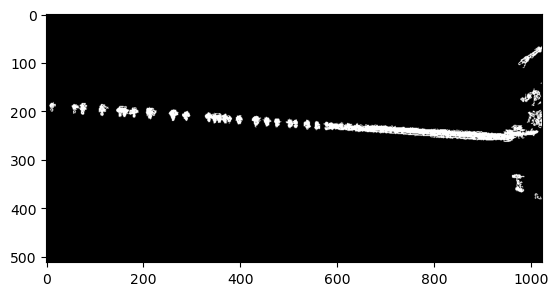

In [9]:
# Display the first frame
fig, ax = plt.subplots()
ax.imshow(image_stack_thresholded[0].T, cmap='gray', vmin=0, vmax=1)
plt.show()

### Morphological Operations for Image Cleanup

A set of morphological operations are included in the repository. While the thresholded stack above does not require further editing, there may be cases where they are required. For example, a thin jet may benefit from inflating the pixels to provide stronger droplet correlations. These operations are discussed in some detail in the `01_example_stack_cleanup_darkfield` notebook. 

Since they are not required for this dataset, we will skip this processing step and continue with the thresholded image.

### Outlier Frame Rejection

In some instances, a single frame may cause issues and need to be removed. In this section, we apply the outlier filtering method to further refine our image stack. First, and for the sake of understanding, we should plot each frame in such a way to visualize any bad images. 

In [10]:
def fullrun_raw_image(stack, ntip_idx, separation=20):
    r'''Make a birds-eye-view image of the full raw image stack
        Useful for a quick view of the full image stack
    '''
    stack = stack[:,:ntip_idx,:]
    n, nx, ny = stack.shape
    g = 0
    for i in range(0, n):
        a = stack[i, :, :].T
        a -= np.median(a, axis=0)
        a = np.pad(a, [[0, separation*n], [0, 0]])
        g += np.roll(a, i*separation, axis=0)
    return np.array(g)

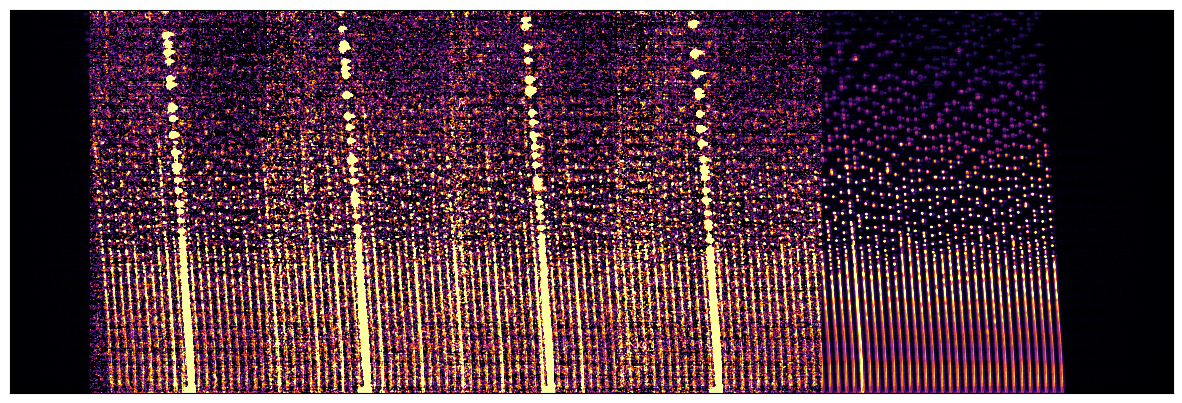

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(fullrun_raw_image(image_stack_filtered, ntip_idx).T, cmap='inferno', vmin=0, vmax=40)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.show()

In the above figure, the individual frames were overlayed on top of each other and shifted to the right to give a "birds-eye view" of the image stack as a whole. To our luck, there are no bad frames in this stack. A bad frame could be a missing jet, or an issue with the a frame being extremely noisy, or anything that does not constitute a stable jet. Regardless, we will run the outlier method to remove for the example.

In [12]:
def outlier_filter(stack, outlier_threshold:int=3):
    s = stack.copy() # make a copy so we don't modify the original image stack
    xs = np.array([np.sum(i) for i in s])
    xm = np.array([np.mean(i) for i in xs])
    xm_idx = np.where(xm > outlier_threshold * np.median(xm))
    s[xm_idx] = np.zeros_like(s[0]) # set any "bad" frames to be completely 0. 
    return s, xm_idx

In [13]:
# Run the outlier filtering method to remove any images that are bad
image_stack, bad_frames = outlier_filter(image_stack_thresholded)

# Print the number of frames removed
print("Number of bad frames: ", len(bad_frames[0]))

Number of bad frames:  4


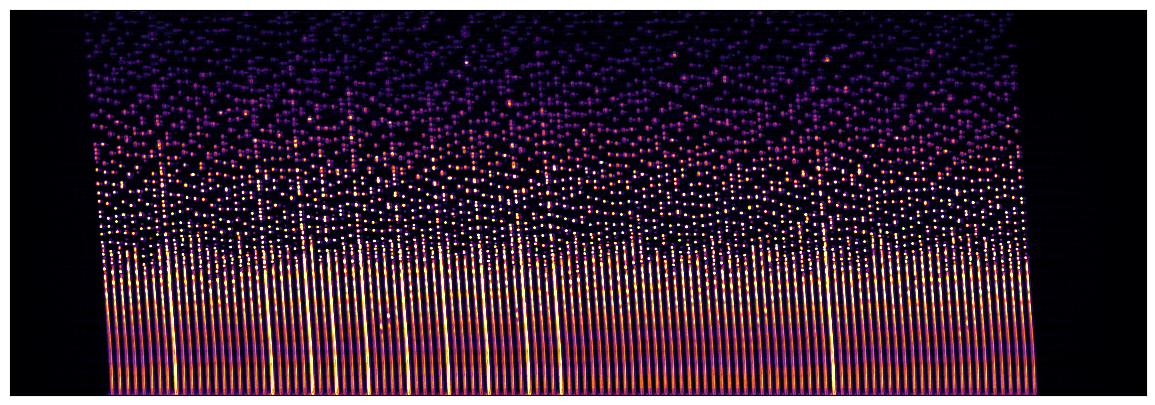

In [14]:
# Display the birds eye view after the outliers have been removed

good_frames_mask = np.ones(len(image_stack_filtered), dtype=bool)
good_frames_mask[bad_frames] = False

fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(fullrun_raw_image(image_stack_filtered[good_frames_mask], ntip_idx).T, cmap='inferno', vmin=0, vmax=40)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.show()

In [15]:
print(image_stack.shape)
image_stack = np.delete(image_stack, bad_frames[0], axis=0)
print(image_stack.shape)

(120, 1024, 512)
(116, 1024, 512)


## Image Segmentation

Image segmentation involves separating an image into distinct regions. In our case, we have three working regions of our jet: 1) the nozzle tip, 2) the jet, and 3) the droplet. In this section, we segment the image stack into these three different regions. The `microjet.regions` module contains multiple methods to do this, but for the sake of example and clarity, we will write the full methods here.

### Nozzle Tip Region

In the previous code, we manually determined the location of the nozzle tip by noting the index position of the nozzle. While this method is the live analysis default, other methods exist to automate this process. Here, we will continue to use the manual index value determination since it's the default in the live analysis. Other methods are explored in the `03_example_segmentation` notebook.

In [16]:
# Remove the nozzle tip from the image stack
image_stack = image_stack[:,:ntip_idx,:]

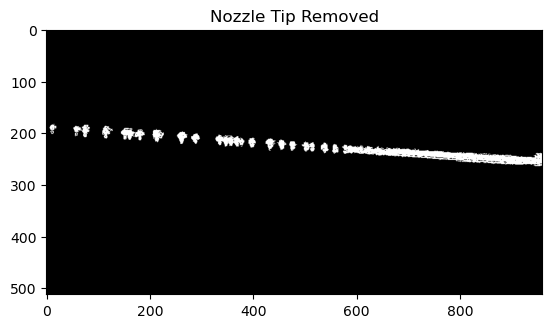

In [17]:
# Display the first frame
fig, ax = plt.subplots()
ax.imshow(image_stack[0].T, cmap='gray', vmin=0, vmax=1)
ax.set_title("Nozzle Tip Removed")
plt.show()

### The Transition Region

Next, we need to determine the location of the transition region (otherwise known as the Rayleigh breakup position), where the jet breaks up into droplets. Multiple methods exist for this in the `microjet.regions` module. The method we will use is defined below.

In [18]:
def find_longest_nonzero_subset(data):
    r"""Given a list of numbers, will determine the 
        longest set of nonzero numbers
    
        Args:
            data (|list|): A list of numbers
        Returns:
            (|list|): The subset of data with the longest stretch of nonzero values
    """
    max_subset = []
    current_max_subset = []
    for i, n in enumerate(data):
        if n > 0:
            current_max_subset.append(i)
            if len(current_max_subset) > len(max_subset):
                max_subset = current_max_subset
        else:
            current_max_subset = []
    return max_subset

def find_jet_breakup_by_longest_nonzero(data):
    """
    Args:
        data (numpy.ndarray): a single 2D cleaned-up image.

    Returns:
        int: An index position corresponding to the jet breakup region. Will
        return None if there is an error.
    """
    x = np.sum(data, axis=1)
    try:
        xs = find_longest_nonzero_subset(x)
        jr_idx = int(xs[0])
    except IndexError:
        jr_idx = -1
    return jr_idx

In [19]:
# Calculate all the transition region index positions using the methods above
transition_idx = np.array([find_jet_breakup_by_longest_nonzero(im) for im in image_stack])

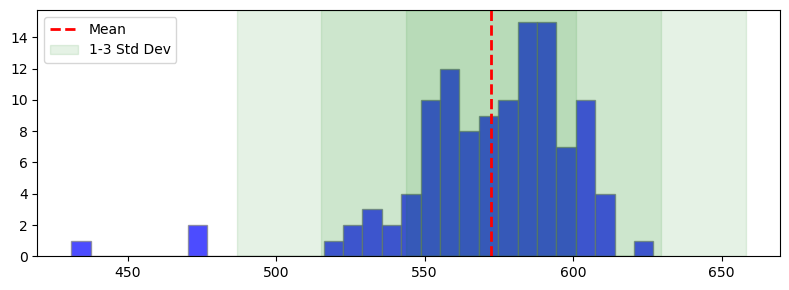

In [20]:
# Plot a histogram of the index positions so we visualize the breakup region dynamics
mean_value = np.mean(transition_idx)
std_dev = np.std(transition_idx)

fig, ax = plt.subplots(figsize=(8,3), tight_layout=True)
# Plot histogram
ax.hist(transition_idx, bins=30, color='blue', alpha=0.7, edgecolor='gray')
# Plot vertical line at mean value
ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
# Plot shaded regions for standard deviations
for i in range(1, 4):
    ax.axvspan(mean_value - i*std_dev, mean_value + i*std_dev, alpha=0.1, color='green')
# Adding a legend to explain the lines and shading
ax.legend(['Mean', '1-3 Std Dev'])
plt.show()


Based on the histogram above, the majority of transition region indices are within one standard deviation from the mean value. There also seems to be a bimodal distribution for these indices. Each individual frame going forward will use its unqiue transition region index to separate the jet and droplets. 

## Analysis Methods

### Speed

The main parameter of interest in this analysis is the jet speed. To calculate this, we employ a cross correlation (CC) technique on the droplet region to find the average droplet displacement across the entirety of the stack. The main methods used for this are `microjet.measure.get_stack_cross_correlation()` and `microjet.measure.js_cross_correlation()`. The general process for this calculation is below.

It should be noted that the CC should only be applied to the droplet region to avoid correlating the jet. 

Once the average displacement is determined using the CC, the jet speed can be calculated as:
\begin{equation}
    U_j = \dfrac{d_{pixel} \delta x_d}{\Delta t},
\end{equation}
where $d_{pixel}$ is the pixel size, $\delta x_d$ is the displacement, and $\Delta t$ is the time between laser pulses. The pixel size and pulse timing are both found in the metadata.

In [21]:
# First, define a few convinience methods
def cross_correlation(a, b):
    """
    Computes the cross-correlation between two input arrays using the Fast Fourier Transform (FFT) method.

    This function computes the cross-correlation of the input arrays (a, b) using FFTs for efficiency. 
    The result is the same size as input arrays and represents the correlation between the two arrays.

    Args:
        a (np.ndarray): First input array for cross-correlation.
        b (np.ndarray): Second input array for cross-correlation.

    Returns:
        np.ndarray: Cross-correlation of a and b, computed using FFTs. The size of returned array is same as input arrays.
    """
    return np.real(np.fft.ifftn(np.fft.fftn(a)*np.conj(np.fft.fftn(b))))

def _pad(stack, ns, nf):
    r'''Convenience function to clean up the numpy.pad code'''
    # Pad to avoid wrap-around effects
    return np.pad(stack.copy(), ((int(ns/2), int(ns/2)), (int(nf/2), int(nf/2))))

def _isolate_droplet_region(stack, idx):
    r"""Masks everything except the droplets

        Args:
            stack (ndarray): The image stack to analyze, defaults to self.jet_region if None.
            idx (ndarray): The list of index values
    """
    jrs = stack.copy()
    for i, im in enumerate(stack):
        if np.isnan(idx[i]):
            jrs[i] = np.zeros_like(im)
        else:
            jrs[i,int(idx[i]):,:] = 0
    return jrs


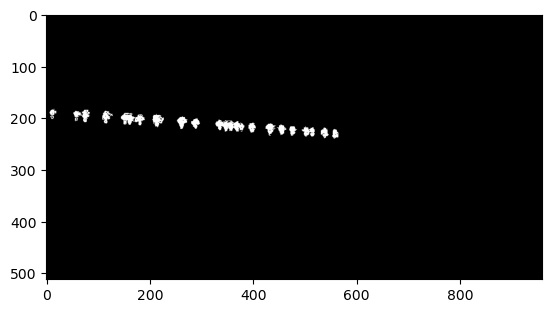

In [22]:
# Isolate the droplets
droplet_region = _isolate_droplet_region(image_stack, transition_idx)

plt.figure()
plt.imshow(droplet_region[0].T, cmap='gray', vmin=0, vmax=1)
plt.show()

In [23]:
# Save the shape of the image stack
nframes, ns, nf = np.shape(droplet_region)

# Calculate the cross correlation of the stack
cc = 0
# correlate with even + 1 frames
for i in range(0, nframes, 2):
    im1 = _pad(droplet_region[i, :, :], ns, nf)
    im2 = _pad(droplet_region[i+1, :, :], ns, nf)
    cc += cross_correlation(im1, im2)
    
# Normalize by the mean value
cc /= np.mean(cc)

# Auto-correlation of the mean image, for background correction (approximately)
mean = _pad(np.mean(droplet_region, axis=0), ns, nf)
acf = cross_correlation(mean, mean)
acf /= np.mean(acf)

# Approximate background correction: subtract auto-correlation of the mean from the mean of cross-correlations
cc -= acf
cc = np.fft.fftshift(cc)

# Remove zero-padding
cc = cc[int(ns/2):ns+int(ns/2), int(nf/2):nf+int(nf/2)]

# Find the peak of the CC.  That's the most common drop displacement.
w = np.where(cc == np.max(cc))
pf = w[1][0] - np.floor(nf/2)
ps = w[0][0] - np.floor(ns/2)

# Calculate the displacement and convert to jet speed
displacement = np.sqrt(pf**2 + ps**2)
jet_speed = displacement * metadata['pixel_size'] * 1e-6 / (metadata['delay'] * 1e-9)

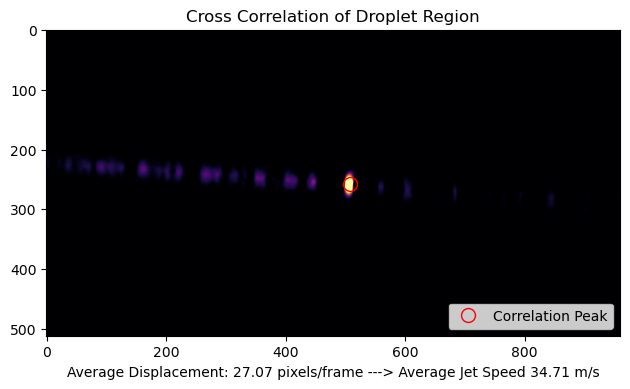

In [24]:
# Visualizing the cross correlation
fig, ax = plt.subplots(tight_layout=True)
ax.imshow(cc.T, cmap='inferno', vmin=0, vmax=25)
ax.plot(w[0][0], w[1][0], 'o', color='red', markerfacecolor='none', markersize=10, label='Correlation Peak')
ax.set_title("Cross Correlation of Droplet Region")
ax.set_xlabel(f"Average Displacement: {displacement:0.02f} pixels/frame ---> Average Jet Speed {jet_speed:0.02f} m/s")
ax.legend(loc='lower right')
plt.show()

### Diameter

Now that we have the jet speed, we can calculate the jet diameter indirectly according to this equation:

\begin{equation}
    D_j = 2 \sqrt{\dfrac{Q}{\pi \, U_j}}
\end{equation}

In [25]:
alpha = 1e-9 / 60  # ul/min to m^3 / sec scale factor
a = (metadata['liquid_flow'] * alpha) / (np.pi * jet_speed)  # units = m^2
jet_diameter = 2 * np.sqrt(a)  # meters
print(f"Jet Diameter = {jet_diameter * 1e6: 0.4f} um")

Jet Diameter =  3.3597 um


### Deviation

Before calculating the jet length and stability, we need to know the deviation angle of the jet. To do this, we make use of the `microjet.regions.HoughJetFit` class. Before proceding with the full image stack, we can use the `display=True` parameter to show the processing steps for a single frame. 

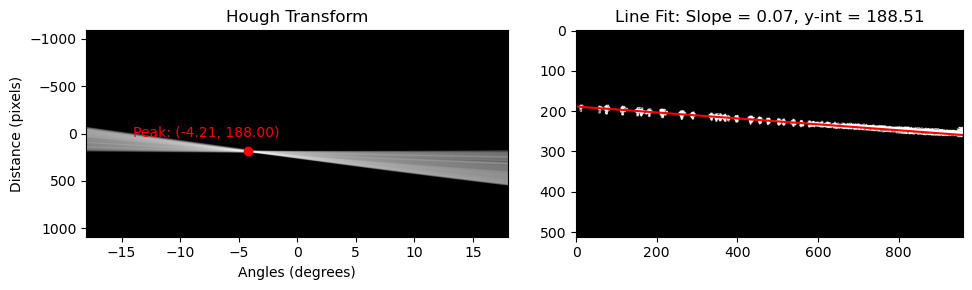

In [26]:
regions.HoughJetFit(image_stack[0], display=True);

Since the Hough Transform worked well, we can now apply it to the full image stack to get fits on a per-frame basis. 

In [27]:
jet_fits = np.array([regions.HoughJetFit(im).get_fit_params()[2] for im in image_stack])

Now, we can calculate the jet deviation angle from the nozzles normal using the code below:


In [28]:
b = np.array([f[0] - f[-1] for i, f in enumerate(jet_fits)])
jet_deviation = np.degrees(np.arctan(b/ns))

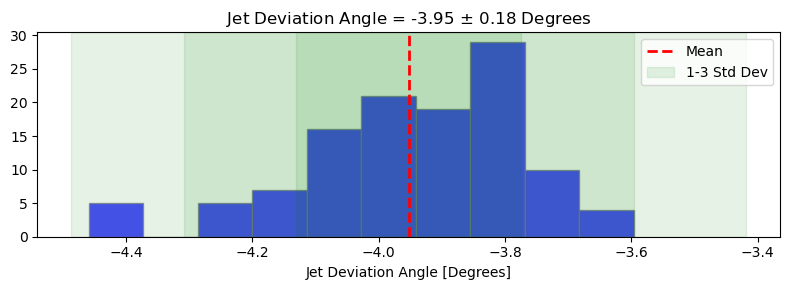

In [29]:
# Plot a histogram of the index positions so we visualize the breakup region dynamics
mean_value = np.nanmean(jet_deviation)
std_dev = np.std(jet_deviation)

fig, ax = plt.subplots(figsize=(8,3), tight_layout=True)
# Plot histogram
ax.hist(jet_deviation, bins=10, color='blue', alpha=0.7, edgecolor='gray')
# Plot vertical line at mean value
ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
# Plot shaded regions for standard deviations
for i in range(1, 4):
    ax.axvspan(mean_value - i*std_dev, mean_value + i*std_dev, alpha=0.1, color='green')
# Adding a legend to explain the lines and shading
ax.legend(['Mean', '1-3 Std Dev'])
ax.set_xlabel("Jet Deviation Angle [Degrees]")
ax.set_title(fr"Jet Deviation Angle = {mean_value:0.2f} $\pm$ {std_dev:0.2f} Degrees")
plt.show()

### Length

Armed with the jet deviation, we can now calculate an accurate jet length as follows.

In [30]:
dx = np.abs(ntip_idx - transition_idx)
jet_length = np.abs(dx * np.cos(jet_deviation)) * metadata['pixel_size']


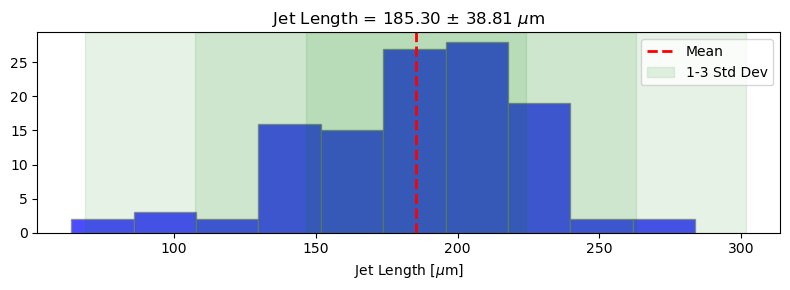

In [31]:
# Plot a histogram of the index positions so we visualize the breakup region dynamics
mean_value = np.nanmean(jet_length)
std_dev = np.std(jet_length)

fig, ax = plt.subplots(figsize=(8,3), tight_layout=True)
# Plot histogram
ax.hist(jet_length, bins=10, color='blue', alpha=0.7, edgecolor='gray')
# Plot vertical line at mean value
ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
# Plot shaded regions for standard deviations
for i in range(1, 4):
    ax.axvspan(mean_value - i*std_dev, mean_value + i*std_dev, alpha=0.1, color='green')
# Adding a legend to explain the lines and shading
ax.legend(['Mean', '1-3 Std Dev'])
ax.set_xlabel(r"Jet Length [$\mu$m]")
ax.set_title(fr"Jet Length = {mean_value:0.2f} $\pm$ {std_dev:0.2f} $\mu$m")
plt.show()

### Stability

A measure of the jets stability is crucial for characterizing regimes of operations, such as whipping. The method for calculating jet stability is as follows.

In [32]:
def get_stability_measure(jet_length, pixel_size, jet_deviation, jet_diameter, percent_dist=0.3):
    """Calculates the stability measure using the current config.

    Returns:
        float: The calculated stability measure
    """
    # determine the "interaction point", i.e., where you want to measure the jet stability
    d = percent_dist * jet_length / pixel_size
    
    ang = jet_deviation * np.pi/180
    dx = d * np.cos(ang)
    y = dx * np.tan(ang)
    ys = np.nanstd(y)
    dj = jet_diameter / pixel_size
    s = ys / dj
    return s


In [33]:
stability = get_stability_measure(jet_length*1e-6, metadata['pixel_size'], jet_deviation, jet_diameter)
print(f"Jet Stability: {stability:0.2f} --- Highly Stable!")

Jet Stability: 0.20 --- Highly Stable!
